In [1]:
import json
from flatten_json import flatten
import pandas as pd
import numpy as np
import Levenshtein

def string_similarity(A, B):

    #calculate the edit distance
    dist = Levenshtein.distance(A, B)
    if dist == 0:
        return 1
    else:
        return 1/dist

def partial_jaccard_similarity(A, B, range=200):

    pay_off = 0.1
    length = len(A) + len(B)
    sim = 0.0

    if len(A) == 0:
        if A == B:
            sim += 1
        else: 
            sim += pay_off
    else:
        for key, value in A.items():
            if key in B.keys():
                length -= 1
                b = B[key]
                if isinstance(value, bool):
                    #print("1*")
                    if value == b:
                        sim += 1
                    else: 
                        sim += pay_off
                elif isinstance(value, int):
                    #print("2*")
                    if (isinstance(b, int) or isinstance(b, float)):
                        #more advanced similarity calculation possible, difference of values if schema has max min limits
                        #range value taken as an argument, default=200
                        value_diff = abs(value - b)
                        if value_diff > range:
                            value_diff = range
                            #print("WARNING!!! Difference in integer values exceeds given range. Value diff: ", abs(value-b), " Range: ", range)
                        sim += (range - value_diff)/range
                        #print("value_sim ", (range - value_diff)/range, " ::: ", value, b)
                    else:
                        pass
                        #print("WARNING!!! Data types for the matching keys must be the same!", type(value), type(b))
                elif isinstance(value, float):
                    #print("3*")
                    if (isinstance(b, float) or isinstance(b, int)):
                        #more advanced similarity calculation possible, difference of values if schema has max min limits
                        #range value taken as an argument, default=200
                        value_diff = abs(value - b)
                        if value_diff > range:
                            value_diff = range
                            #print("WARNING!!! Difference in float values exceeds given range. Value diff: ", abs(value-b), " Range: ", range)
                        sim += (range - value_diff)/range
                        #print("value_sim ", (range - value_diff)/range, " ::: ", value, b)
                    else:
                        pass
                        #print("WARNING!!! Data types for the matching keys must be the same!", type(value), type(b))
                elif isinstance(value, str):
                    #print("4*")
                    #str comparison
                    if isinstance(b, str):
                        sim += string_similarity(value, b)
                        #print("str_sim ", string_similarity(value, b), " = ", value, " | ", b )
                    else: 
                        sim += pay_off
                # elif isinstance(value, None):
                else:
                    #print("51*")
                    #print("attention", value, b)
                    if value == b:
                        sim += 1
                    else: 
                        sim += pay_off

    #print("sim : ", sim)
    #print("length : ", length)
    res = sim
    if length != 0:
        res /= length
    return res
  


In [2]:
minlength = 999999999

def build_shingles(path: str):
    global minlength
    f1 = open(path)
    data1 = json.load(f1)
    flat_json1 = flatten(data1)
    set1 = set([ str(value) for value in flat_json1.values()])
    set1.update(set([ str(key) for key in flat_json1.keys()]))
    if len(set1) < minlength:
        minlength = len(set1)
    return set1

def build_mydata(path: str):
    f1 = open(path)
    data1 = json.load(f1)
    flat_json1 = flatten(data1)
    return flat_json1

def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

def one_hot(shingles: set, vocab: dict):
    vec = np.zeros(len(vocab))
    for shingle in shingles:
        idx = vocab[shingle]
        vec[idx] = 1
    return vec

In [3]:
data = []
mydata = []
for i in range(1,41):
    data.append(build_shingles('.\myscenarios\data' +  str(i) +'.json'))
    mydata.append(build_mydata('.\myscenarios\data' +  str(i) +'.json'))
    #print(i)

print("min length: ", minlength)

min length:  132


In [4]:
#data

vocab = build_vocab(data)

In [5]:
# one-hot encode our shingles
shingles_1hot = []
for shingle_set in data:
    shingles_1hot.append(one_hot(shingle_set, vocab))
# stack into single numpy array
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape
#shingles_1hot

(40, 1528)

In [6]:
def minhash_arr(vocab: dict, resolution: int):
    length = len(vocab.keys())
    arr = np.zeros((resolution, length))
    for i in range(resolution):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
    return arr.astype(int)

def get_signature(minhash, vector):
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    # use index locations to pull only +ve positions in minhash
    shingles = minhash[:, idx]
    # find minimum value in each hash vector
    signature = np.min(shingles, axis=1)
    return signature

In [7]:
arr = minhash_arr(vocab, 100)

signatures = []

for vector in shingles_1hot:
    signatures.append(get_signature(arr, vector))

# merge signatures into single array
signatures = np.stack(signatures)
signatures.shape

(40, 100)

In [8]:
print(signatures[1])

[ 1 10  7  9  1  6 33  3 20  8 18  9  7  1 18 23 14  6  6 12  3  2 13 15
 14  7  5 51  6  1 14 15  2 15  4  4 20  5  3  1  5  2 23  2  6  5  5  2
 15  6  1  7  6 16 40  2  4  3 41  7 21  1 16 12 23  1 19  5  9 17  5 13
  2  9 19  7 13 10  4 10 12 21  4 22 19  7  7 16  8 25 18  4 23  6  2  4
  2  5  1 40]


In [9]:
from itertools import combinations

class LSH:
    buckets = []
    counter = 0
    def __init__(self, b):
        self.b = b
        for i in range(b):
            self.buckets.append({})

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = int(l / self.b)
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)
    
    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            subvec = ','.join(subvec)
            if subvec not in self.buckets[i].keys():
                self.buckets[i][subvec] = []
            self.buckets[i][subvec].append(self.counter)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for bucket_band in self.buckets:
            keys = bucket_band.keys()
            for bucket in keys:
                hits = bucket_band[bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

In [10]:
b = 20

lsh = LSH(b)

for signature in signatures:
    lsh.add_hash(signature)

In [11]:
lsh.buckets[:20]

[{'1,10,7,17,7': [0],
  '1,10,7,9,1': [1],
  '1,10,6,5,7': [2, 4, 5, 12],
  '1,10,6,5,1': [3],
  '1,10,2,12,4': [6],
  '1,10,2,5,4': [7],
  '1,10,1,1,7': [8],
  '1,10,7,7,7': [9],
  '1,4,5,7,7': [10],
  '1,3,5,7,2': [11],
  '1,10,6,5,5': [13, 14],
  '1,7,6,5,7': [15],
  '1,10,6,2,5': [16],
  '1,10,7,1,1': [17],
  '1,10,7,5,5': [18],
  '1,4,5,1,6': [19, 20, 21, 22],
  '1,10,7,2,7': [23, 31, 32],
  '1,10,3,2,16': [24],
  '1,10,3,2,7': [25],
  '1,10,6,1,11': [26, 27, 28, 29],
  '1,10,6,1,7': [30],
  '1,10,6,2,7': [33, 35, 36, 37],
  '1,1,6,3,8': [34],
  '1,8,6,2,3': [38],
  '1,2,7,1,7': [39]},
 {'6,8,3,38,8': [0],
  '6,33,3,20,8': [1],
  '6,9,3,19,8': [2],
  '6,12,3,7,8': [3, 16, 25, 31, 32, 35, 36, 37],
  '6,12,3,5,8': [4],
  '6,12,3,19,7': [5],
  '5,5,3,10,2': [6],
  '6,12,3,19,8': [7, 12],
  '6,12,3,35,8': [8],
  '6,5,3,10,2': [9],
  '6,5,3,2,2': [10],
  '4,5,2,2,2': [11],
  '6,14,3,7,4': [13, 14, 24],
  '6,11,3,7,8': [15],
  '6,14,3,17,4': [17],
  '6,1,1,7,8': [18],
  '2,2,3,2,2': [19

In [12]:
lsh.check_candidates()
candidate_pairs = lsh.check_candidates()

In [13]:
len(candidate_pairs)

184

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

In [15]:
pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'jaccard': [],
    'jaccard_similarity': [],
    'cosine': [],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
#sample_size = 50_000
for x in range(40):
    for y in range(x,40):
        vector_x = signatures[x]
        vector_y = signatures[y]
        candidate = 1 if (x, y) in candidate_pairs or x==y else 0
        cosine = cosine_similarity([vector_x], [vector_y])[0][0]
        pairs = pairs.append({
                'x': x,
                'y': y,
                'jaccard': jaccard(set(vector_x), set(vector_y)),
                'partial_similarity' : partial_jaccard_similarity(mydata[x], mydata[y]),
                'cosine': cosine,
                'candidate': candidate
            }, ignore_index=True)

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\1903428596.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\1903428596.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\1903428596.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\1903428596.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs = pairs.append({
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\1903428596.py:20: FutureWarning: The fram

<AxesSubplot: xlabel='cosine', ylabel='candidate'>

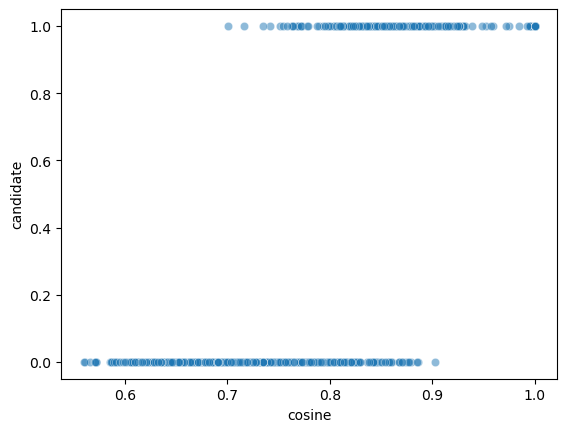

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.5)

In [17]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

<AxesSubplot: xlabel='cosine', ylabel='candidate'>

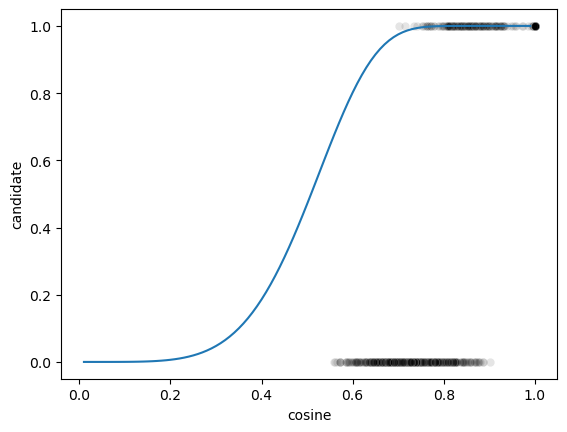

In [18]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine', y='candidate', alpha=0.1, color='k')

<AxesSubplot: xlabel='cosine_norm', ylabel='candidate'>

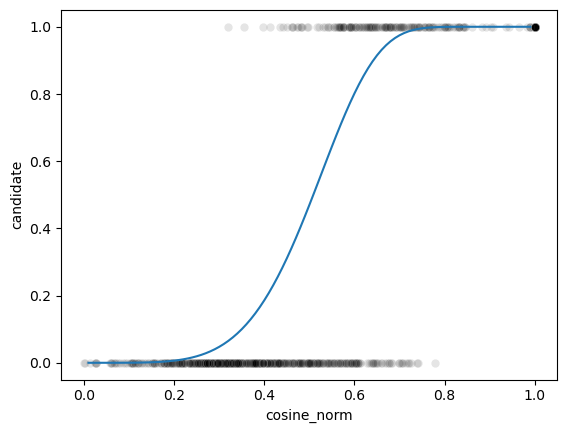

In [19]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidate', alpha=0.1, color='k')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14812\2354034427.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({


<AxesSubplot: xlabel='s', ylabel='P'>

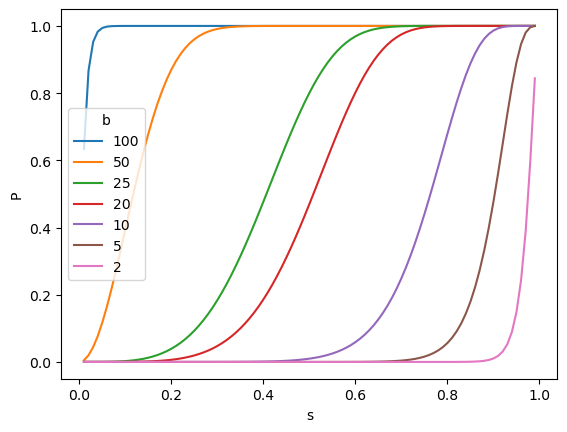

In [20]:
probs = pd.DataFrame({
    'P': [],
    's': [],
    'b': []
})

for b in [100, 50, 25, 20, 10, 5, 2]:
    r = int(100 / b)
    s_scores = np.arange(0.01, 1, 0.01)
    P_scores = [probability(s, r, b) for s in s_scores]
    probs = probs.append(pd.DataFrame({
        'P': P_scores,
        's': s_scores,
        'b': [str(b)]*len(s_scores)
    }), ignore_index=True)

sns.lineplot(data=probs, x='s', y='P', hue='b')

<AxesSubplot: xlabel='jaccard', ylabel='candidate'>

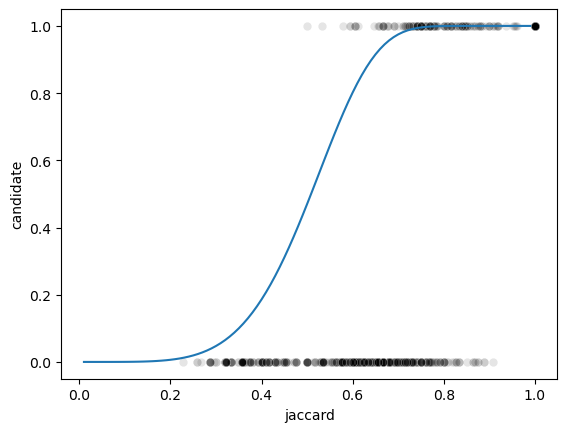

In [21]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.1, color='k')

<AxesSubplot: xlabel='partial_similarity', ylabel='candidate'>

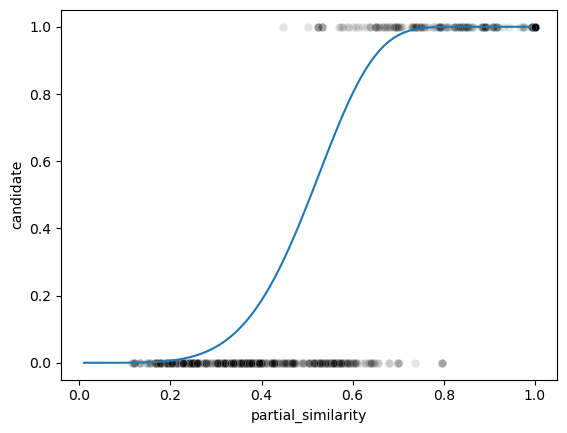

In [22]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='partial_similarity', y='candidate', alpha=0.1, color='k')